<a href="https://colab.research.google.com/github/MosheWasserb/PyTorchNotbooks/blob/master/IPS_Chalenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install transformers

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import preprocessing
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
from sklearn.linear_model import LinearRegression

### Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

Importing the dataset

In [34]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')



Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# load data
data=pd.read_csv(r"/gdrive/My Drive/IL/ips.csv")

text_col=data.columns.values[2] 
category_col=data.columns.values[3]

# Filter data with NaN in Case Description or Case Category rows

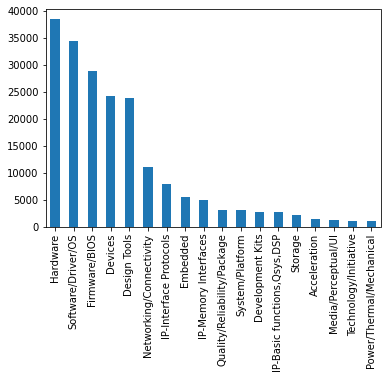

In [36]:
data_filter= data[data[category_col].isin(data[category_col].value_counts()[data[category_col].value_counts()>1000].index)]
data_filter[category_col].value_counts().plot.bar()

Init and set data

In [0]:
TEST_SIZE=0.2
RANDOM_STATE=42
SAMPLE_SIZE = 6400
MIN_SIZE_PER_CAT = 1000

max_bert_len = 512

BATCH_SIZE=64
EPOCHS =5
HIDDEN_SIZE=768

catagories=list(set(data_filter[category_col].unique()))
OUTPUT_DIM= len(catagories)   #num of catagories

In [0]:
batch_1 = data_filter.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE);

In [0]:
train_texts, test_texts, train_labels, test_labels = train_test_split(batch_1[text_col],batch_1[category_col], test_size=TEST_SIZE,random_state=RANDOM_STATE)

In [64]:
len(train_texts), len(test_texts), len(train_labels), len(test_labels)

(25600, 6400, 25600, 6400)

1. Ngram baseline model

In [38]:
#CounterVecorizer(ngram_range=(1,3), min_df=0.2, max_df=0.7, max_featured=10000, stop_words="english")
ngramCount_baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3),min_df=0.2, max_df=0.7, max_featured=10000), LogisticRegression()).fit(train_texts, train_labels)
ngramCount_baseline_predicted = ngramCount_baseline_model.predict(test_texts)
print(classification_report(test_labels, ngramCount_baseline_predicted))
print(confusion_matrix(test_labels, ngramCount_baseline_predicted))

                         precision    recall  f1-score   support

           Design Tools       0.00      0.00      0.00         1
                Devices       0.00      0.00      0.00         0
          Firmware/BIOS       0.00      0.00      0.00         2
               Hardware       1.00      0.43      0.60         7
 IP-Interface Protocols       0.00      0.00      0.00         1
Networking/Connectivity       0.00      0.00      0.00         1
     Software/Driver/OS       0.67      0.50      0.57         4

               accuracy                           0.31        16
              macro avg       0.24      0.13      0.17        16
           weighted avg       0.60      0.31      0.41        16



2. Glove mean Logistic

In [0]:
# define dict to hold a word and its vector
glove = {}
# read the word embeddings file ~820MB
f = open('/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()
# check the length
len(glove) # 400000

In [0]:
def MeanSentenceGlove(texts):
# create vector for each sentences
# list to hold vector 
  sentence_vectors = []
# create vector for each clean normalized sentence
  for i in texts:
      if len(i) != 0:
          v = sum([glove.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
          print(len(i))
      else:
          v = np.zeros((100,))
      sentence_vectors.append(v)
  print('Total vectors created:',len(sentence_vectors))
  return(sentence_vectors)

In [0]:
x=MeanSentenceGlove(train_texts)

In [69]:
train_glove = MeanSentenceGlove(train_texts)
test_glove = MeanSentenceGlove(test_texts)
Glove_baseline_model=LogisticRegression()
Glove_baseline_model.fit(train_glove, train_labels)
Glove_baseline_predicted = Glove_baseline_model.predict(test_glove)
print(classification_report(test_labels, Glove_baseline_predicted))

Total vectors created: 25600
Total vectors created: 6400
                             precision    recall  f1-score   support

               Acceleration       0.00      0.00      0.00        53
               Design Tools       0.40      0.53      0.46       752
           Development Kits       0.00      0.00      0.00        87
                    Devices       0.33      0.40      0.36       746
                   Embedded       0.00      0.00      0.00       181
              Firmware/BIOS       0.34      0.40      0.37       897
                   Hardware       0.37      0.57      0.44      1249
IP-Basic functions,Qsys,DSP       0.00      0.00      0.00        95
     IP-Interface Protocols       0.00      0.00      0.00       248
       IP-Memory Interfaces       0.22      0.01      0.02       182
        Media/Perceptual/UI       0.00      0.00      0.00        47
    Networking/Connectivity       0.20      0.02      0.04       363
   Power/Thermal/Mechanical       0.00      0

In [45]:
temp = MeanSentenceGlove(train_texts)

Total vectors created: 64


In [49]:
temp[0]

array([-1.72058775e-01,  1.01186715e-01,  2.14352733e-01, -7.34664493e-02,
       -4.34852188e-02, -6.91256528e-03, -1.31348609e-01,  1.65758546e-01,
       -4.88014905e-02,  1.02324748e-02,  2.00103522e-02, -1.98267716e-02,
        2.55017488e-01,  9.50495425e-03,  8.03879057e-02, -1.32130190e-01,
        1.14037360e-01,  9.92224532e-02, -2.73742180e-01,  8.72590658e-02,
        1.11170401e-01, -1.47256223e-01,  1.46394240e-01,  6.44764811e-02,
        9.73778333e-02, -1.27645675e-01, -5.99177731e-02, -2.76227505e-01,
        2.51875203e-02, -9.08544052e-02, -8.46196721e-02,  2.76321747e-01,
       -9.89671069e-02,  5.94537011e-03,  7.38322848e-02,  2.40559815e-01,
        7.15423796e-02,  1.13786478e-01, -3.65373762e-02, -1.22951703e-01,
       -2.32323468e-01, -1.46435150e-01,  4.02971010e-02, -1.87463677e-01,
       -7.46559021e-02,  2.25805851e-02,  1.48564692e-01, -1.39551711e-01,
       -3.18098280e-02, -4.22261205e-01,  4.90865595e-02, -1.51482435e-02,
        7.54734518e-02,  

3. BERT Fine-tune

Load BERT pre-trained model

In [14]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

## Want Roberta instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
BertModel = model_class.from_pretrained(pretrained_weights)

Tokenization

In [15]:
tokenized = batch_1[text_col].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1210 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (732 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors


Limit tokenized to 512 max_bert_len

In [0]:
#padded = np.array([if (len(i)>0) i=3, for i in tokenized.values])
tokenized_limted = []
for i in tokenized.values:
  if len(i)>max_bert_len:
    tokenized_limted.append(i[:max_bert_len])
  else:
    tokenized_limted.append(i)
     


Padding 

In [0]:
padded = np.array([i + [0]*(max_bert_len-len(i)) for i in tokenized_limted])

Our dataset is now in the `padded` variable, we can view its dimensions below:

In [22]:
np.array(padded).shape

(80, 512)

Masking

In [23]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(80, 512)

Convert to tensors

In [0]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

**And now Deep Learning**

Biniarizatiom

In [0]:
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(catos) & set(catagories) for catos in batch_1[[category_col]].values]
bin_catagories = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_catagories.tolist())

target_tensor=torch.max(target_tensor_bin,1)[1]

Convert to tensor

In [0]:
train_tokens_tensor, test_tokens_tensor, train_masks_tensor, test_masks_tensor = train_test_split(input_ids,attention_mask,test_size=TEST_SIZE,random_state=RANDOM_STATE)
train_y_tensor, test_y_tensor  = train_test_split(target_tensor,test_size=TEST_SIZE,random_state=RANDOM_STATE)

Dataloader 

In [0]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

Define model

In [0]:
class BertMultiClassifier(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(BertMultiClassifier, self).__init__()
        # Need to define the right layer 
        self.bert = model_class.from_pretrained(pretrained_weights)
        #self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(HIDDEN_SIZE, OUTPUT_DIM)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        last_hidden_states = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = last_hidden_states[0][:,0,:]
        #dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(pooled_output)
        proba = self.sigmoid(linear_output)
        return linear_output

In [0]:
bert_clf = BertMultiClassifier()
optimizer = torch.optim.Adam(bert_clf.parameters(), lr=3e-6)
criterion = torch.nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss.  Check BCEWithLogitsLoss()

In [31]:
losses = []
steps = []
step = 0
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        probas = bert_clf(token_ids, masks)
        
        batch_loss = criterion(probas, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        #clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("{0}/{1} loss: {2} ".format(step_num, len(train_y_tensor) / BATCH_SIZE, train_loss / (step_num + 1)))
        losses.append(batch_loss.item())
        steps.append(step)
        step += 1

convert_to_pickle(bert_clf, "/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/BertClfTemp.pkl")


Epoch:  10
3/4.0 loss: 2.4851730465888977 


Evaluation

In [0]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t for t in batch_data)

        probas = bert_clf(token_ids, masks)
        
        bert_predicted += list(torch.max(probas,1)[1])

In [0]:
print(classification_report(test_y_tensor, bert_predicted))
print(confusion_matrix(test_y_tensor, bert_predicted))

How good is this score? What can we compare it against? Let's first look at a dummy classifier:

In [0]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.242 (+/- 0.01)


XXXXXX

### 2.1 Init


**Logistic Distilation with BERT**

In [0]:
bert_clf = load_from_pickle("/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/DistilBERTfineTune6400tr5epochs.pkl")

Bimarization of lables and create target_tensor

**Use unlabeled data (load from pkl)**

Init

Init/Load logits for labeled and unlabeled data

In [0]:
#convert_to_pickle([train_logits, unlabeled_logits], "/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/DistilBERTfineTune6400tr10epochsLogistList.pkl") 


In [0]:
train_logits_load, unlabeled_logits_load = load_from_pickle("/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/DistilBERTfineTune6400tr10epochsLogistList.pkl")

In [0]:
unlabeled_logits_pd = pd.DataFrame(unlabeled_logits_load) # convert to pandas format 

Init/Set train/test texts and labels

In [0]:
# retain only text that contain less that 70 tokens to avoid too much padding
#all_ulabeled_data["token_size"] = all_ulabeled_data["text"].apply(lambda x: len(x.split(' ')))
#all_ulabeled_data = all_ulabeled_data.loc[all_ulabeled_data['token_size'] <= 70].copy()

In [0]:
TRAINING_SIZE = 6400
TEST_SIZE = 1600
TRAINING_PLUS_TEST_SIZE = 8000
UNLABELED_SIZE = 6400
RANDOM_SEED = 42
TEST_SIZE=0.2

labeled_data = data.sample(n=TRAINING_PLUS_TEST_SIZE, random_state=RANDOM_SEED);     
all_ulabeled_text = data.drop(labeled_data.index)[text_col]

unlabeled_texts=all_ulabeled_text.sample(n=64000, random_state=42)  # Must be RANDOM_SEED=42 as loaded from pkl

unlabeled_logits = unlabeled_logits_pd.sample(n=UNLABELED_SIZE, random_state=RANDOM_SEED)
unlabeled_texts = unlabeled_texts.sample(n=UNLABELED_SIZE, random_state=RANDOM_SEED)

train_texts, test_texts, train_labels, test_labels = train_test_split(labeled_data[text_col], labeled_data[category_col],test_size=TEST_SIZE,random_state=RANDOM_SEED)

Init/Build train_y_tensor and test_y_tensor

In [0]:
catagories=list(set(data[category_col].unique()))

mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(catos) & set(catagories) for catos in batch_1[[category_col]].values]
bin_catagories = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_catagories.tolist())

target_tensor=torch.max(target_tensor_bin,1)[1]
train_y_tensor, test_y_tensor  = train_test_split(target_tensor,test_size=TEST_SIZE,random_state=RANDOM_SEED)

In [0]:
print(vec_matrix)

<bound method _cs_matrix.toarray of <6400x149035 sparse matrix of type '<class 'numpy.int64'>'
	with 301263 stored elements in Compressed Sparse Row format>>


Simple regression - N-gram count only (baseline)

In [0]:
ngramCount_baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)
ngramCount_baseline_predicted = ngramCount_baseline_model.predict(test_texts)
print(classification_report(test_labels, ngramCount_baseline_predicted))

              precision    recall  f1-score   support

       anger       0.90      0.64      0.75       229
        fear       0.80      0.61      0.69       175
         joy       0.72      0.92      0.81       517
        love       0.83      0.38      0.52       129
     sadness       0.78      0.89      0.83       485
    surprise       0.83      0.29      0.43        65

    accuracy                           0.77      1600
   macro avg       0.81      0.62      0.67      1600
weighted avg       0.79      0.77      0.76      1600



BERT Embedding (freeze BERT)

BERT Finetuning 

Distill with training

In [0]:
#from sklearn import linear_model
#reg = linear_model.Ridge(alpha=.5)
#reg = linear_model.Lasso(alpha=.1)

In [0]:
distilled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(train_texts, train_logits_load)
distilled_predicted_logits = distilled_model.predict(test_texts)
distilled_bert_predicted=torch.max(torch.tensor(distilled_predicted_logits),1)[1]
print(classification_report(test_y_tensor, distilled_bert_predicted))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       229
           1       0.81      0.79      0.80       175
           2       0.79      0.94      0.86       517
           3       0.85      0.52      0.64       129
           4       0.88      0.91      0.90       485
           5       0.87      0.52      0.65        65

    accuracy                           0.84      1600
   macro avg       0.86      0.75      0.79      1600
weighted avg       0.85      0.84      0.84      1600



Distill with unlabeled samples 

In [0]:
unlabeled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(unlabeled_texts, unlabeled_logits)
unlabeled_predicted_logits = unlabeled_model.predict(test_texts)
unlabeled_bert_predicted=torch.max(torch.tensor(unlabeled_predicted_logits),1)[1]
print(classification_report(test_y_tensor,unlabeled_bert_predicted))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       229
           1       0.77      0.77      0.77       175
           2       0.77      0.89      0.82       517
           3       0.71      0.50      0.58       129
           4       0.85      0.89      0.87       485
           5       0.94      0.49      0.65        65

    accuracy                           0.81      1600
   macro avg       0.82      0.72      0.75      1600
weighted avg       0.81      0.81      0.80      1600



Distill with unlabeled samples + training 

In [0]:
mix_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(np.concatenate((train_texts,unlabeled_texts),axis=0), np.concatenate((train_logits_load,unlabeled_logits.to_numpy())))
mix_predicted_logits = mix_model.predict(test_texts)
mix_bert_predicted=torch.max(torch.tensor(mix_predicted_logits),1)[1]
print(classification_report(test_y_tensor,mix_bert_predicted))

NameError: ignored

Distill with STS data

In [0]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [0]:
class BertMultiClassifier(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(BertMultiClassifier, self).__init__()
        # Need to define the right layer 
        self.bert = model_class.from_pretrained(pretrained_weights)
        #self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(HIDDEN_SIZE, OUTPUT_DIM)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        last_hidden_states = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = last_hidden_states[0][:,0,:]
        #dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(pooled_output)
        proba = self.sigmoid(linear_output)
        return linear_output
        
bert_clf = load_from_pickle("/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/DistilBERTfineTune6400tr5epochs.pkl")

In [0]:
labeled_data = data.sample(n=TRAINING_PLUS_TEST_SIZE, random_state=RANDOM_SEED); 
train_texts, test_texts, train_labels, test_labels = train_test_split(labeled_data['text'], labeled_data['emotions'],test_size=TEST_SIZE,random_state=RANDOM_SEED)

In [0]:
catagories=list(set(data[category_col].unique()))

mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(catos) & set(catagories) for catos in batch_1[[category_col]].values]
bin_catagories = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_catagories.tolist())

target_tensor=torch.max(target_tensor_bin,1)[1]
train_y_tensor, test_y_tensor  = train_test_split(target_tensor,test_size=TEST_SIZE,random_state=RANDOM_SEED)

In [0]:
BATCH_SIZE=64
sts_data = df.sample(n=6400, random_state=42)
sts_unlabeled_texts = sts_data[0]
sts_logits=build_bert_logits(sts_unlabeled_texts,bert_clf, tokenizer, batch_size=BATCH_SIZE)

In [0]:
sts_unlabeled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(sts_unlabeled_texts, sts_logits)
sts_unlabeled_predicted_logits = sts_unlabeled_model.predict(test_texts)
sts_unlabeled_bert_predicted=torch.max(torch.tensor(sts_unlabeled_predicted_logits),1)[1]
print(classification_report(test_y_tensor,sts_unlabeled_bert_predicted))

              precision    recall  f1-score   support

           0       0.10      0.00      0.01       229
           1       0.33      0.02      0.03       175
           2       0.39      0.86      0.54       517
           3       0.60      0.02      0.04       129
           4       0.48      0.42      0.45       485
           5       0.55      0.09      0.16        65

    accuracy                           0.41      1600
   macro avg       0.41      0.24      0.20      1600
weighted avg       0.39      0.41      0.32      1600



In [0]:
def build_bert_logits(texts, bert_clf,tokenizer, batch_size):

  tokenized = texts.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)

  input_ids = torch.tensor(padded)  
  attention_mask = torch.tensor(attention_mask)

  tokens_tensor = torch.tensor(input_ids)
  masks_tensor = torch.tensor(attention_mask)

  dataset = TensorDataset(tokens_tensor, masks_tensor)
  dataloader = DataLoader(dataset, batch_size)

  bert_clf.eval()
  list_logits = []
  with torch.no_grad():
      for step_num, batch_data in enumerate(dataloader):

          token_ids, masks = tuple(t for t in batch_data)

          logits = bert_clf(token_ids, masks)
        
          list_logits += list(logits)

          print("{0}/{1}".format(step_num, len(dataset) / batch_size))

  list_logits_numpy= (i.numpy() for i in list_logits)
  logits = np.vstack(list_logits_numpy)
  return(logits)


**N-gram plus Glove embedding** 
Example code: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/3%20-%20Faster%20Sentiment%20Analysis.ipynb 

https://colab.research.google.com/github/MosheWasserb/PyTorchNotbooks/blob/master/Glove_CNN_MultiClass.ipynb#scrollTo=tnUazzVHSuB6

Simple logistic by replace CounteVecorize with mean sentence Glove 

In [0]:
labeled_data = data.sample(n=TRAINING_PLUS_TEST_SIZE, random_state=RANDOM_SEED); 
train_texts, test_texts, train_labels, test_labels = train_test_split(labeled_data['text'], labeled_data['emotions'],test_size=TEST_SIZE,random_state=RANDOM_SEED)

In [0]:
# define dict to hold a word and its vector
glove = {}
# read the word embeddings file ~820MB
f = open('/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()
# check the length
len(glove) # 400000

In [0]:


# create vector for each sentences
# list to hold vector 
sentence_vectors = []
# create vector for each clean normalized sentence
for i in clean_sentences:
    if len(i) != 0:
        v = sum([glove.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    sentence_vectors.append(v)
print('Total vectors created:',len(sentence_vectors))

In [0]:
Glove_baseline_model = make_pipeline(MeanSentenceGlove()), LogisticRegression()).fit(train_texts, train_labels)
Glove_baseline_predicted = Glove_baseline_model.predict(test_texts)
print(classification_report(test_labels, Glove_baseline_predicted))

Distill with Back translate

Distill with VAT